#### Confounding variable analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from scipy import stats
from IPython.display import display, HTML


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
folder = '/root/capsule/data/filtered_data_session/filtered_data_101724.csv' # Updated** as of 10/17/24
df = pd.read_csv(folder)

/tmp/ipykernel_5057/4128915244.py:2: DtypeWarning: Columns (6,7,8,26,27,28,29,30,146,147,148,149,150,151,152,153,154,155,156,157,158) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(folder)


In [26]:
# Let's look at individual trainer foraging performance scores first 

indiv_df = df[['subject_id', 'user_name', 'foraging_performance', 'session_date']]
# Convert session_date to dates 
indiv_df['session_date'] = pd.to_datetime(indiv_df['session_date'])

# Abbreviate for readability in plots 
indiv_df['date'] = indiv_df['session_date'].dt.strftime('%b %d')

# Filter for selected user
user = 'Xinxin Yin'

bt_df = indiv_df[indiv_df['user_name'] == user]
bt_df = bt_df.sort_values(by=['subject_id', 'session_date'])
print(bt_df.shape)
display(HTML(bt_df.to_html()))

(426, 5)


/tmp/ipykernel_5057/3062011095.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_df['session_date'] = pd.to_datetime(indiv_df['session_date'])
/tmp/ipykernel_5057/3062011095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_df['date'] = indiv_df['session_date'].dt.strftime('%b %d')


,subject_id,user_name,foraging_performance,session_date,date
3476,708322,Xinxin Yin,0.70,2024-03-14,Mar 14
3457,708322,Xinxin Yin,0.63,2024-03-15,Mar 15
3442,708322,Xinxin Yin,0.61,2024-03-18,Mar 18
3526,711254,Xinxin Yin,0.33,2024-03-11,Mar 11
3515,711254,Xinxin Yin,0.62,2024-03-12,Mar 12
3491,711254,Xinxin Yin,0.64,2024-03-13,Mar 13
3470,711254,Xinxin Yin,0.35,2024-03-14,Mar 14
3452,711254,Xinxin Yin,0.60,2024-03-15,Mar 15
3435,711254,Xinxin Yin,0.68,2024-03-18,Mar 18
3392,711254,Xinxin Yin,0.60,2024-03-21,Mar 21


In [27]:
# Create pivot tables for average foraging performance with dims: (subject x time)

bt_pivot_table = bt_df.pivot_table(
    values='foraging_performance', 
    index='subject_id', 
    columns='session_date',
    aggfunc='mean',
    fill_value=0
)

In [28]:
# Scaling average pivot table values and create new dataframe
#scaler = StandardScaler()

#scaled_fp_values = scaler.fit_transform(bt_pivot_table.values)


bt_df = pd.DataFrame(bt_pivot_table.values, index=bt_pivot_table.index, columns=bt_pivot_table.columns)

other_users_subjects = indiv_df[indiv_df['user_name'] != user]['subject_id'].unique()

bt_df['trained_by_others'] = bt_df.index.isin(other_users_subjects)

bt_df = bt_df[bt_df['trained_by_others'] == False]

bt_df.head(20)

session_date,2024-03-11 00:00:00,2024-03-12 00:00:00,2024-03-13 00:00:00,2024-03-14 00:00:00,2024-03-15 00:00:00,2024-03-18 00:00:00,2024-03-19 00:00:00,2024-03-21 00:00:00,2024-03-22 00:00:00,2024-03-25 00:00:00,...,2024-10-03 00:00:00,2024-10-04 00:00:00,2024-10-07 00:00:00,2024-10-08 00:00:00,2024-10-09 00:00:00,2024-10-10 00:00:00,2024-10-11 00:00:00,2024-10-14 00:00:00,2024-10-15 00:00:00,trained_by_others
subject_id,,,,,,,,,,,,,,,,,,,,,
711254,0.33,0.62,0.64,0.35,0.60,0.68,0.00,0.60,0.69,0.62,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
713378,0.45,0.40,0.60,0.51,0.51,0.62,0.00,0.69,0.39,0.45,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
716866,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
716868,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
717474,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
744329,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.69,0.77,0.71,0.71,0.73,0.72,0.75,0.74,0.00,False
744331,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.73,0.70,0.71,0.71,0.75,0.74,0.80,0.78,0.00,False


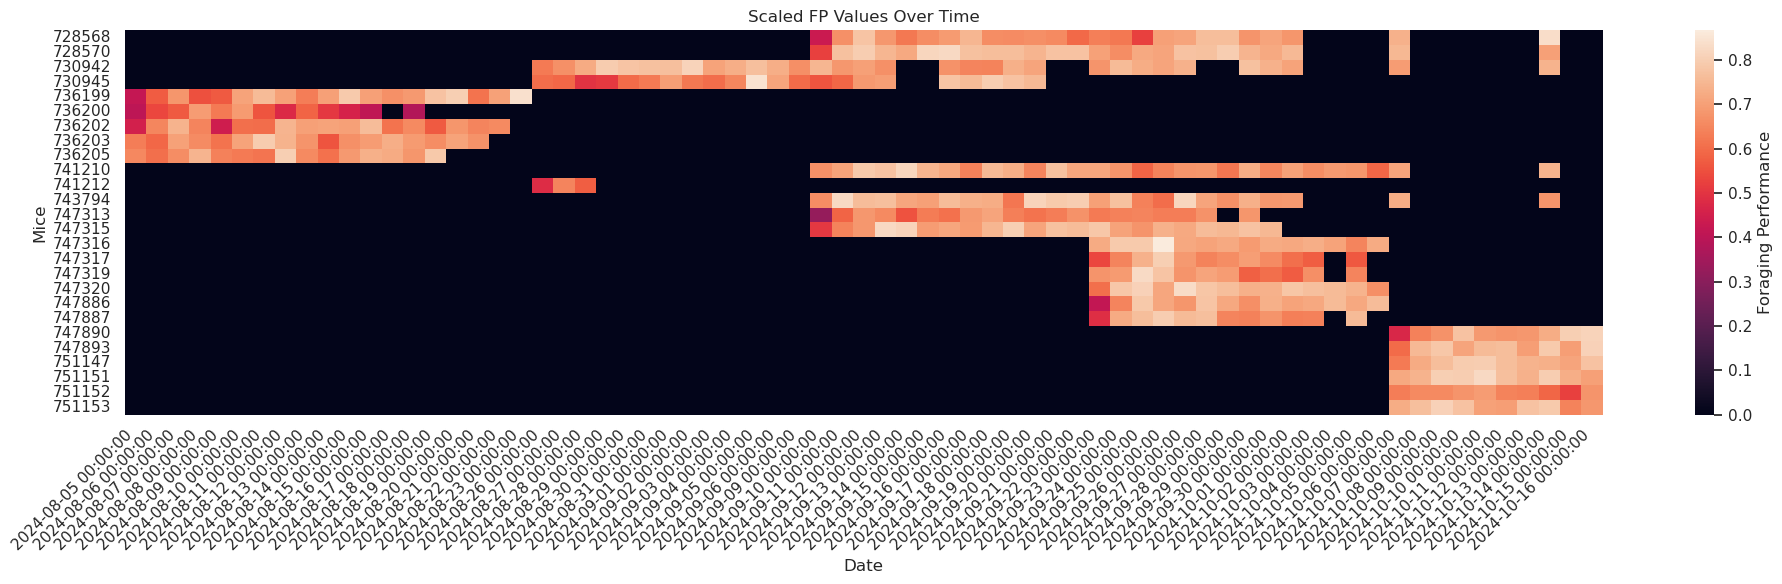

In [6]:
# Exclude float column 
bt_df_heatmap = bt_df.drop(columns='trained_by_others')

# Plot foraging performance heatmap
sns.set_theme()

plt.figure(figsize=(20,6))
sns.heatmap(data=bt_df_heatmap, cbar_kws={'label': 'Foraging Performance'})
plt.xticks(rotation=45, ha='right')
plt.title('Scaled FP Values Over Time')
plt.xlabel('Date')
plt.ylabel('Mice')

plt.tight_layout()

plt.show()

In [7]:
def analyze_subject(row):

    # Find non-zero values and idxs
    non_zero = row[row != 0]
    non_zero_idx = np.where(row != 0)[0]

    if len(non_zero) <= 1:
        return {'subject_id': row.name, 'continuous': True, 'breaks': 0, 'break_length': []}
    
    # Find gaps between breaks 
    gaps = np.diff(non_zero_idx)

    # If all gaps = 1, then continous else
    if np.all(gaps == 1):
        return {'subject_id': row.name, 'continuous': True, 'breaks': 0, 'break_length': []}

    # Count gaps and lengths 
    breaks = np.sum(gaps > 1)
    break_length = gaps[gaps > 1] - 1

    return {
        'subject_id': row.name,
        'continuous': False,
        'breaks': breaks,
        'break_length': break_length.tolist()
    }

In [8]:
results = bt_df_heatmap.apply(analyze_subject, axis=1)

results_df = pd.DataFrame(results.tolist())

continuous_subjects = results_df[results_df['continuous']]['subject_id'].tolist()
discontinuous_subjects = results_df[~results_df['continuous']]

print("Subjects with continuous foraging performance:")
print(continuous_subjects)
print("\nSubjects with breaks in foraging performance:")
for _, row in discontinuous_subjects.iterrows():
    print(f"Subject {row['subject_id']}:")
    print(f"  Number of breaks: {row['breaks']}")
    print(f"  Break lengths: {row['break_length']}")
    print()

Subjects with continuous foraging performance:
[736199, 736202, 736203, 736205, 741212, 747315, 747316, 747320, 747886, 747890, 747893, 751147, 751151, 751152, 751153]

Subjects with breaks in foraging performance:
Subject 728568:
  Number of breaks: 2
  Break lengths: [4, 6]

Subject 728570:
  Number of breaks: 2
  Break lengths: [4, 6]

Subject 730942:
  Number of breaks: 5
  Break lengths: [2, 2, 2, 4, 6]

Subject 730945:
  Number of breaks: 1
  Break lengths: [2]

Subject 736200:
  Number of breaks: 1
  Break lengths: [1]

Subject 741210:
  Number of breaks: 1
  Break lengths: [6]

Subject 743794:
  Number of breaks: 2
  Break lengths: [4, 6]

Subject 747313:
  Number of breaks: 1
  Break lengths: [1]

Subject 747317:
  Number of breaks: 1
  Break lengths: [1]

Subject 747319:
  Number of breaks: 1
  Break lengths: [1]

Subject 747887:
  Number of breaks: 1
  Break lengths: [1]



In [16]:
def performance_difference(row):
    non_zero = row[row != 0]
    non_zero_idx = np.where(row != 0)[0]

    if len(non_zero_idx) <= 1:
        return {
            'subject_id': row.name,
            'mean_performance_difference': 0,
            'num_breaks': 0
        }

    breaks = np.where(np.diff(non_zero_idx) > 1)[0]
    
    if len(breaks) == 0:
        return {
            'subject_id': row.name,
            'mean_performance_difference': 0,
            'num_breaks': 0
        }

    differences = []
    for i in range(len(breaks)):
        if i == 0:
            last_value_before = non_zero.iloc[breaks[i]]
            first_value_after = non_zero.iloc[breaks[i] + 1]
        else:
            last_value_before = non_zero.iloc[breaks[i]]
            first_value_after = non_zero.iloc[breaks[i] + 1]
        
        differences.append(first_value_after - last_value_before)

    mean_difference = sum(differences) / len(differences)

    return {
        'subject_id': row.name,
        'mean_performance_difference': mean_difference,
        'num_breaks': len(breaks)
    }

In [20]:
results = bt_df_heatmap.apply(performance_difference, axis=1)
results_df = pd.DataFrame(results.tolist())

In [21]:
# Clean 

cleaned_df = results_df[(results_df['mean_performance_difference'] != 0) | (results_df['num_breaks'] != 0)]

# Sort

cleaned_df = cleaned_df.sort_values('num_breaks', ascending=False)

# Reset index

cleaned_df.reset_index(drop = True)

pd.set_option('display.float_format', '{:.2f}'.format)
print(cleaned_df.to_string(index=False))

 subject_id  mean_performance_difference  num_breaks
     730942                         0.01           5
     728568                         0.08           2
     728570                        -0.03           2
     743794                        -0.00           2
     730945                         0.08           1
     736200                        -0.03           1
     741210                         0.03           1
     747313                         0.01           1
     747317                        -0.01           1
     747319                        -0.02           1
     747887                         0.12           1


<Axes: xlabel='num_breaks', ylabel='mean_performance_difference'>

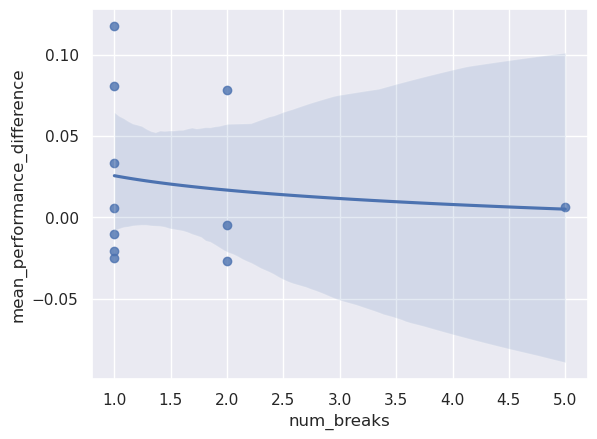

In [25]:
sns.regplot(cleaned_df, x='num_breaks', y='mean_performance_difference', logx=True)